<a href="https://colab.research.google.com/github/RamonRossello/RamonRosselloCifre-TFM/blob/main/TFM_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo y dataset

El objetivo principal consiste
en, a partir del uso de los datos adecuados, facilitar una herramienta y un conjunto de
técnicas provenientes del proceso de Minería de Datos que permita predecir y determinar el precio de un determinado vehículo en Australia a cualquier posible comprador.


# Información general del data set

In [ ]:
# Importamos las librerías necesarias y adaptamos las configuraciones pertinentes.
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime # Necesario para la obtención de la variable de salida.
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

A continuación se importan los tres datasets involucrados

In [ ]:
# Fuente interna. Datos de precios de coches.
car = pd.read_csv('Australian Vehicle Prices.csv')

In [ ]:
car[car['FuelConsumption'] == '0 L / 100 km']['FuelType'].value_counts()

Diesel      198
Electric    105
Unleaded     57
Premium      14
Leaded        2
Hybrid        1
Name: FuelType, dtype: int64

In [ ]:
car['FuelType'].value_counts()

Unleaded    6985
Diesel      4905
Premium     3377
Hybrid       652
-            637
Electric     115
Other         42
LPG           15
Leaded         5
Name: FuelType, dtype: int64

In [ ]:
# Índices de precio
pr = pd.read_excel('Price_Index_Australia.xlsx')

In [ ]:
# Cambio de moneda
coin = pd.read_csv('euro-daily-hist_1999_2022.csv')

# Unificación de datasets

El siguiente paso consiste en unificar toda la información de cara a facilitar la comprensión del ejercicio. Es decir, se calcula el cambio de moneda medio anual del dólar australiano al euro y el índice de precio medio anual, añadiéndose así dichas columnas en el dataset car, realizando cada unión a partir del año de fabricación de cada vehículo y el año del valor medio de cambio de moneda o del índice de precio.

In [ ]:
# Se añade la columna Year en los datasets coin y pr, que no tienen Missing
coin[coin.columns[0]] = pd.to_datetime(coin[coin.columns[0]])
pr[pr.columns[0]] = pd.to_datetime(pr[pr.columns[0]])
coin['Year'] = coin[coin.columns[0]].dt.year
pr['Year'] = pr[pr.columns[0]].dt.year
print(pd.isnull(coin['Year']).any(), pd.isnull(pr['Year']).any())

False False


In [ ]:
# Se identifican los Missing Values del dólar australiana (definidos por un guion) y se imputan por el método fill
ad = coin.columns[1]
ip = pr.columns[1]
aux = []
for i in coin[ad]:
  if str(i) == '-':
    aux.append(None)
  else :
    aux.append(float(i))

coin[ad] = aux
coin[ad].fillna(method='ffill', inplace=True)

# Se comprueba que el índice de precio no tiene Missing Values y se convierte a numérico
print('Missing Values del índice de precio: ', pr[ip].isnull().sum(), '\n')
pr[ip]= pr[ip].astype('float64')
print('¿Tiene Missing Values el cambio de moneda? ', pd.isnull(coin[ad]).any(), '\n')

MV del índice de precio:  0 

MV del cambio de moneda:  False 



In [ ]:
# Se obtiene el valor medio anual del cambio de dólar australiano a euro y del índice del precio
coinGroup = coin.groupby(['Year']).mean()[ad]
priceGroup = pr.groupby(['Year']).mean()[ip]

<ipython-input-9-1b46c6dc792e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  coinGroup = coin.groupby(['Year']).mean()[ad]
<ipython-input-9-1b46c6dc792e>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  priceGroup = pr.groupby(['Year']).mean()[ip]


In [ ]:
# Se imputa el único Missing Value en el año de fabricación del dataset car (método fill) y se convierte a entera la columna
print('Missing values de Year en el datset car: ', car['Year'].isnull().sum())
car['Year'].fillna(method='ffill', inplace=True)
print('Missing values de Year en el datset car: ', car['Year'].isnull().sum())
car['Year'] = car['Year'].astype('Int64')

Missing values de Year en el datset car:  1
Missing values de Year en el datset car:  0


In [ ]:
# Se añade en car el valor medio anual del cambio de moneda entre dólar australiano y el índice de precio medio anual
aux1 = []
aux2 = []
for i in car['Year']:
  if i in coinGroup.index:
    aux1.append(float(coinGroup[i]))
  else:
    aux1.append(None)
  if i in priceGroup.index:
    aux2.append(float(priceGroup[i]))
  else:
    aux2.append(None)

car['DollarAustralian'] = aux1
car['PriceIndex'] = aux2

De esta forma, ya se dispone de toda la información centralizada en el dataset car, cuyo resumen es el siguiente

In [ ]:
print('El dataset contiene', car.shape[0], 'filas y', car.shape[1], 'columnas.')
print('Las columnas, con sus correspondientes tipos, son las siguientes:\n', car.dtypes)

El dataset contiene 16734 filas y 21 columnas.
Las columnas, con sus correspondientes tipos, son las siguientes:
 Brand                 object
Year                   Int64
Model                 object
Car/Suv               object
Title                 object
UsedOrNew             object
Transmission          object
Engine                object
DriveType             object
FuelType              object
FuelConsumption       object
Kilometres            object
ColourExtInt          object
Location              object
CylindersinEngine     object
BodyType              object
Doors                 object
Seats                 object
Price                 object
DollarAustralian     float64
PriceIndex           float64
dtype: object


# Transformación de los datos

Adecuación de tipos de variables.

In [ ]:
# Adecuación de tipos y comprobación si son enteros.

#Variable Engine
l = []
for i in car['Engine']:
  aux1 = str(i).find(',') # Devuelve -1 si no lo encuentra.
  aux2 = str(i).find('L') # Devuelve -1 si no lo encuentra.
  if aux1 != -1 and aux2 != -1:
    l.append(float(i[aux1+2:aux2-1]))
  elif i == '0 L' or i == '2 L':
    l.append(float(i[0]))
  elif i == '-' or pd.isna(i) or i == '4 cyl':
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en Engine con formato no identificado.")

car['Engine'] = l


# Variable CylindersinEngine -> Cylinders
l = []
for i in car['CylindersinEngine']:
  aux = str(i).find('c')
  if aux != -1:
    l.append(int(i[0:aux]))
  elif i == '0 L' or i == '2 L' or i == '-' or pd.isna(i):
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en CylindersinEngine con formato no identificado.")

car['CylindersinEngine'] = l
car.rename(columns = {list(car)[14]:'Cylinders'}, inplace=True)
car['Cylinders'] = car['Cylinders'].astype('Int64')

# Variable FuelConsumption
l = []
for i in car['FuelConsumption']:
  aux = str(i).find('L')
  if aux != -1:
    l.append(float(i[0:aux]))
  elif i =='-' or pd.isna(i) :
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en FuelConsumption con formato no identificado.")

car['FuelConsumption'] = l

# Variable Doors

l = []
for i in car['Doors']:
  aux1 = str(i).find('D')
  aux2 = str(i).find('S')
  if aux1 != -1:
    l.append(int(i[0:aux1]))
  elif  i =='-' or pd.isna(i) or aux2 != -1:
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en Doors con formato no identificado.")

car['Doors']=l
car['Doors'] = car['Doors'].astype('Int64')

# Variable Seats

l = []
for i in car['Seats']:
  aux = str(i).find('S')
  if aux != -1:
    l.append(int(i[0:aux]))
  elif  i =='-' or pd.isna(i) :
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en Seats con formato no identificado.")

car['Seats'] = l
car['Seats'] = car['Seats'].astype('Int64')

# Variable kilometres
l = []
for i in car['Kilometres']:
  if str(i).isnumeric():
    l.append(float(i))
  elif  i =='-' or pd.isna(i) or i == '- / -':
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en Kilometres con formato no identificado.")

car['Kilometres'] = l

# Variable Price
l = []
for i in car['Price']:
  if str(i).isnumeric():
    l.append(float(i))
  elif  i =='-' or pd.isna(i) or i == 'POA':
    l.append(None)
  else:
    print("Si se pinta esta línea hay un valor en Price con formato no identificado.")

car['Price'] = l

In [ ]:
print('Las columnas, con sus correspondientes tipos, son las siguientes:\n', car.dtypes)

Las columnas, con sus correspondientes tipos, son las siguientes:
 Brand                object
Year                  Int64
Model                object
Car/Suv              object
Title                object
UsedOrNew            object
Transmission         object
Engine              float64
DriveType            object
FuelType             object
FuelConsumption     float64
Kilometres          float64
ColourExtInt         object
Location             object
Cylinders             Int64
BodyType             object
Doors                 Int64
Seats                 Int64
Price               float64
DollarAustralian    float64
PriceIndex          float64
dtype: object


A continuación se determinan las columnas a eliminar por tener un número excesivo de categorías.

In [ ]:
# Columnas a eliminar por tener un número excesivo de categorías.
cols_to_drop = ['Brand', 'Model', 'Car/Suv', 'Title', 'ColourExtInt', 'Location']
for i in cols_to_drop:
  print(i, ":")
  print(car[i].value_counts())
  print("\n")

Brand :
Toyota         2784
Hyundai        1239
Mazda          1179
Holden         1087
Ford           1055
               ... 
Proton            1
Daewoo            1
Hummer            1
Rolls-Royce       1
Packard           1
Name: Brand, Length: 76, dtype: int64


Model :
Hilux          430
Corolla        405
Ranger         398
Landcruiser    370
I30            366
              ... 
Celerio          1
R-Class          1
Vectra           1
ES300            1
120              1
Name: Model, Length: 781, dtype: int64


Car/Suv :
SUV                             5921
Hatchback                       2365
Ute / Tray                      2068
Sedan                           1898
Wagon                            577
                                ... 
Werribee Hyundai                   1
Bay City Holden Used.              1
Auto Mega Warehouse Brisbane       1
Consign-A-Car P/L (Kedron)         1
Australian Vehicle Locators        1
Name: Car/Suv, Length: 618, dtype: int64


Title :
2019 H

In [ ]:
# Eliminación
cols_to_drop = ['Brand', 'Model', 'Car/Suv', 'Title', 'ColourExtInt', 'Location']
car = car.drop(cols_to_drop, axis=1)

Seguidamete, se intenta reducir las categorías de las variables categóricas.

In [ ]:
# Transformación
cols_to_reduce = ['UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 'BodyType']
for i in cols_to_reduce:
  print(i, ":")
  print(car[i].value_counts())
  print("\n")

UsedOrNew :
USED    14994
NEW      1227
DEMO      512
Name: UsedOrNew, dtype: int64


Transmission :
Automatic    14530
Manual        1952
-              251
Name: Transmission, dtype: int64


DriveType :
Front    6978
4WD      3143
AWD      3113
Rear     2350
Other    1149
Name: DriveType, dtype: int64


FuelType :
Unleaded    6985
Diesel      4905
Premium     3377
Hybrid       652
-            637
Electric     115
Other         42
LPG           15
Leaded         5
Name: FuelType, dtype: int64


BodyType :
SUV             6907
Hatchback       2697
Ute / Tray      2512
Sedan           1983
Wagon           1232
Commercial       610
Coupe            336
Convertible      131
Other             23
People Mover      21
Name: BodyType, dtype: int64




Text(0.5, 1.0, 'Tipos de combustible después')

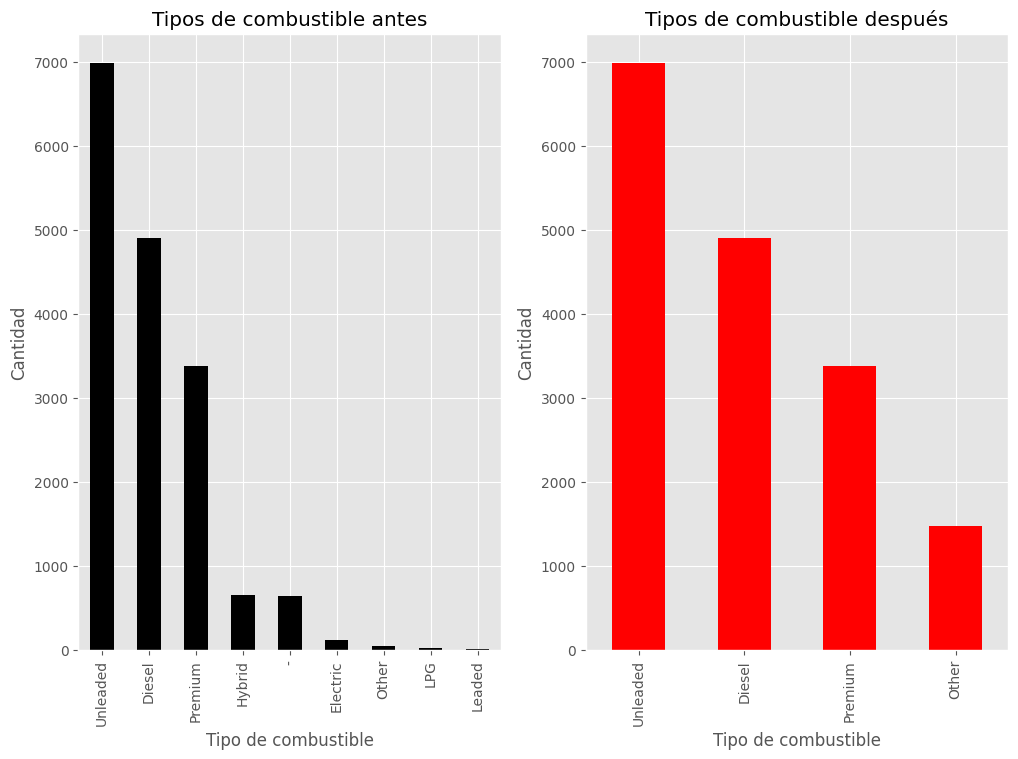

In [ ]:

l = []
for i in car['FuelType']:
  if i != 'Unleaded' and i != 'Diesel' and i != 'Premium':
    l.append('Other')
  else :
    l.append(i)

s = pd.Series(l)
plt.subplot(1, 2, 1)
car['FuelType'].value_counts().plot.bar(color = 'black')
plt.xlabel('Tipo de combustible')
plt.ylabel('Cantidad')
plt.title('Tipos de combustible antes')

plt.subplot(1, 2, 2)
s.value_counts().plot.bar(color = 'red')
plt.xlabel('Tipo de combustible')
plt.ylabel('Cantidad')
plt.title('Tipos de combustible después')



Text(0.5, 1.0, 'Estilos de coche después')

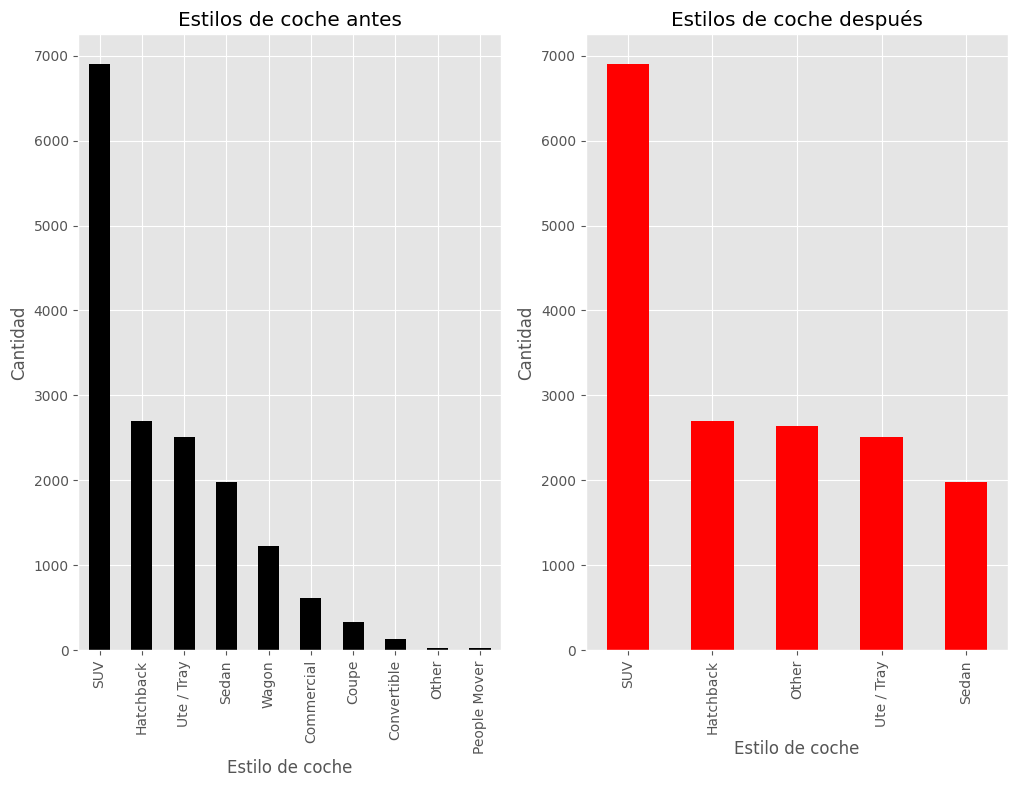

In [ ]:
l = []
for i in car['BodyType']:
  if i != 'SUV' and i != 'Hatchback' and i != 'Ute / Tray' and i != 'Sedan':
    l.append('Other')
  else :
    l.append(i)

s = pd.Series(l)
plt.subplot(1, 2, 1)
car['BodyType'].value_counts().plot.bar(color = 'black')
plt.xlabel('Estilo de coche')
plt.ylabel('Cantidad')
plt.title('Estilos de coche antes')

plt.subplot(1, 2, 2)
s.value_counts().plot.bar(color = 'red')
plt.xlabel('Estilo de coche')
plt.ylabel('Cantidad')
plt.title('Estilos de coche después')

Se ve conveniente reducir las categorías de las variables del tipo de combustible y el estilo del coche, obteneiendo los resultados de los gráficos en rojo anteriores.

In [ ]:
# Transformación
l = []
for i in car['FuelType']:
  if i != 'Unleaded' and i != 'Diesel' and i != 'Premium':
    l.append('Other')
  else :
    l.append(i)

car['FuelType'] = l

l = []
for i in car['BodyType']:
  if i != 'SUV' and i != 'Hatchback' and i != 'Ute / Tray' and i != 'Sedan':
    l.append('Other')
  else :
    l.append(i)

car['BodyType'] = l



# Missing Values

In [ ]:
# Listado por porcentajes.
for col in car.columns:
    pct_missing = np.mean(car[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100, 2)))

Year - 0.0%
UsedOrNew - 0.01%
Transmission - 0.01%
Engine - 10.02%
DriveType - 0.01%
FuelType - 0.0%
FuelConsumption - 10.15%
Kilometres - 3.54%
Cylinders - 10.65%
BodyType - 0.0%
Doors - 10.01%
Seats - 10.19%
Price - 0.32%
DollarAustralian - 0.54%
PriceIndex - 17.4%


In [ ]:
car['DriveType'].value_counts()


Front    6978
4WD      3143
AWD      3113
Rear     2350
Other    1149
Name: DriveType, dtype: int64

Text(0.5, 1.0, 'Mapa de calor de valores faltantes por variable')

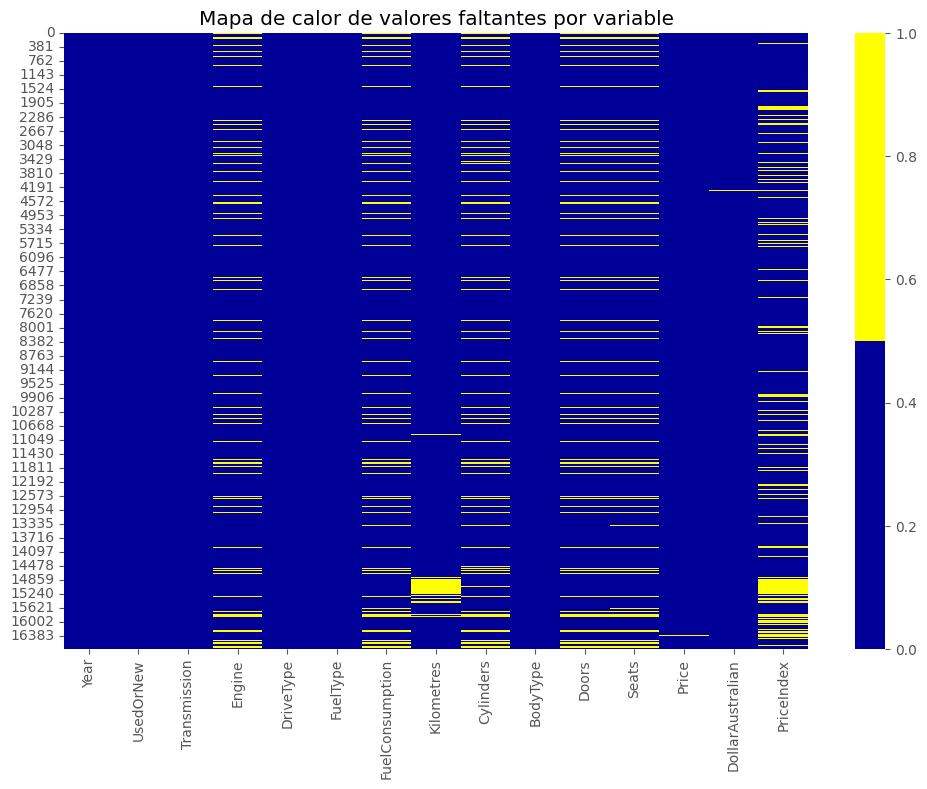

In [ ]:
# Mapa de calor de Missing Values.
cols = car.columns
colours = ['#000099', '#ffff00'] # especificamos los colores - amarillo es missing. Azul no es missing.
sns.heatmap(car[cols].isnull(), cmap=sns.color_palette(colours))
plt.title('Mapa de calor de valores faltantes por variable')

In [ ]:
# Categóricas
# UsedOrNew -> Lo añadimos a USED
# Transmission -> Lo añadimos a automatic
col_top = ['UsedOrNew', 'Transmission']

for col in col_top:
    missing = car[col].isnull()
    num_missing = np.sum(missing)
    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        top = car[col].describe()['top'] # impute with the most frequent value.
        car[col] = car[col].fillna(top)

# Transmission "-"" a Automatic
l = []
for i in car['Transmission']:
  if i == '-':
    l.append('Automatic')
  else :
    l.append(i)

car['Transmission'] = l
# DriveType a Other
l = []
for i in car['DriveType']:
  if pd.isna(i):
    l.append('Other')
  else :
    l.append(i)

car['DriveType'] = l

In [ ]:
# Numéricas
# impute the missing values and create the missing value indicator variables for each numeric column.
num_mi_col = ['Engine', 'FuelConsumption', 'Kilometres', 'Cylinders', 'Doors', 'Seats', 'DollarAustralian', 'PriceIndex', 'Price']
for col in num_mi_col:
    missing = car[col].isnull()
    num_missing = np.sum(missing)
    print('imputing missing values for: {}'.format(col))
    med = car[col].median()
    if col in ('Cylinders', 'Doors', 'Seats'):
      med = int(med)
    car[col] = car[col].fillna(med)

# Comprobamos que los  campos ya no presentan missing values.
for col in num_mi_col:
  print('Missing values en', col, car[col].isnull().sum())

imputing missing values for: Engine
imputing missing values for: FuelConsumption
imputing missing values for: Kilometres
imputing missing values for: Cylinders
imputing missing values for: Doors
imputing missing values for: Seats
imputing missing values for: DollarAustralian
imputing missing values for: PriceIndex
imputing missing values for: Price
Missing values en Engine 0
Missing values en FuelConsumption 0
Missing values en Kilometres 0
Missing values en Cylinders 0
Missing values en Doors 0
Missing values en Seats 0
Missing values en DollarAustralian 0
Missing values en PriceIndex 0
Missing values en Price 0


In [ ]:
print('El dataset contiene', car.shape[0], 'filas y', car.shape[1], 'columnas.')
print('Las columnas, con sus correspondientes tipos, son las siguientes:\n', car.dtypes)

El dataset contiene 16033 filas y 15 columnas.
Las columnas, con sus correspondientes tipos, son las siguientes:
 Year                  Int64
UsedOrNew            object
Transmission         object
Engine              float64
DriveType            object
FuelType             object
FuelConsumption     float64
Kilometres          float64
Cylinders             Int64
BodyType             object
Doors                 Int64
Seats                 Int64
Price               float64
DollarAustralian    float64
PriceIndex          float64
dtype: object


# Selección de características

No hay variables de entrada excesivamente correlacionadas. Aunque Seats y Doors parece que no están relacionadas con Price, las dejamos por si existe otra relación que no sea lineal. Se justificará su uso o no después en el futuro modelo lineal generalizado.

In [ ]:
# Variables numéricas relacionadas
corr_matrix = car.corr()
corr_matrix

<ipython-input-25-0c54bf6cecfa>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = car.corr()


,Year,Engine,FuelConsumption,Kilometres,Cylinders,Doors,Seats,Price,DollarAustralian,PriceIndex
Year,1.000000,-0.182471,-0.258235,-0.696667,-0.172040,0.066991,0.014712,0.351451,0.123917,0.746127
Engine,-0.182471,1.000000,0.557007,0.232809,0.804203,-0.315065,0.038717,0.255675,0.012041,-0.150460
FuelConsumption,-0.258235,0.557007,1.000000,0.218492,0.509391,-0.169453,0.076615,0.021749,-0.026594,-0.243990
Kilometres,-0.696667,0.232809,0.218492,1.000000,0.140161,-0.112854,0.001587,-0.347778,-0.179824,-0.578763
Cylinders,-0.172040,0.804203,0.509391,0.140161,1.000000,-0.238393,0.016651,0.334112,0.000717,-0.147121
Doors,0.066991,-0.315065,-0.169453,-0.112854,-0.238393,1.000000,0.369554,-0.177394,-0.011402,0.058987
Seats,0.014712,0.038717,0.076615,0.001587,0.016651,0.369554,1.000000,-0.041135,0.008452,0.024777
Price,0.351451,0.255675,0.021749,-0.347778,0.334112,-0.177394,-0.041135,1.000000,0.149495,0.278544
DollarAustralian,0.123917,0.012041,-0.026594,-0.179824,0.000717,-0.011402,0.008452,0.149495,1.000000,0.110870
PriceIndex,0.746127,-0.150460,-0.243990,-0.578763,-0.147121,0.058987,0.024777,0.278544,0.110870,1.000000


In [ ]:
corr_matrix[(corr_matrix > 0.6) | (corr_matrix < -0.6)]

,Year,Engine,FuelConsumption,Kilometres,Cylinders,Doors,Seats,Price,DollarAustralian,PriceIndex
Year,1.000000,NaN,NaN,-0.696667,NaN,NaN,NaN,NaN,NaN,0.746127
Engine,NaN,1.000000,NaN,NaN,0.804203,NaN,NaN,NaN,NaN,NaN
FuelConsumption,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometres,-0.696667,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Cylinders,NaN,0.804203,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
Doors,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Seats,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
DollarAustralian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
PriceIndex,0.746127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


<BarContainer object of 3 artists>

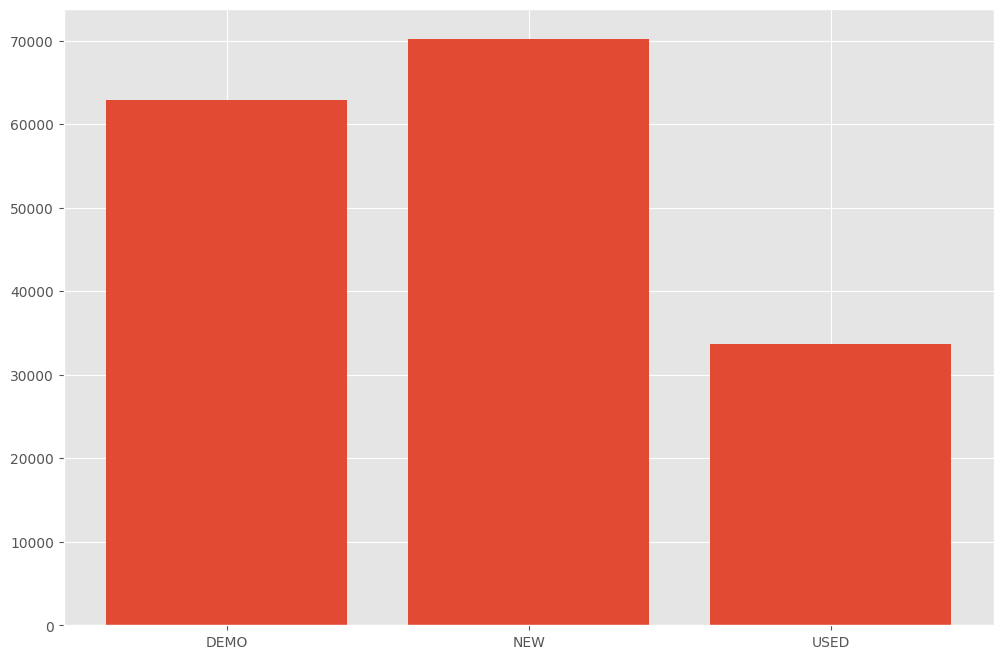

In [ ]:
# Varibales categóricas
UsedOrNew_grouped = car[['UsedOrNew', 'Price']].groupby('UsedOrNew').mean().reset_index()
# Creating a bar chart
plt.bar(UsedOrNew_grouped ['UsedOrNew'], UsedOrNew_grouped['Price'])



Text(0, 0.5, 'Precio')

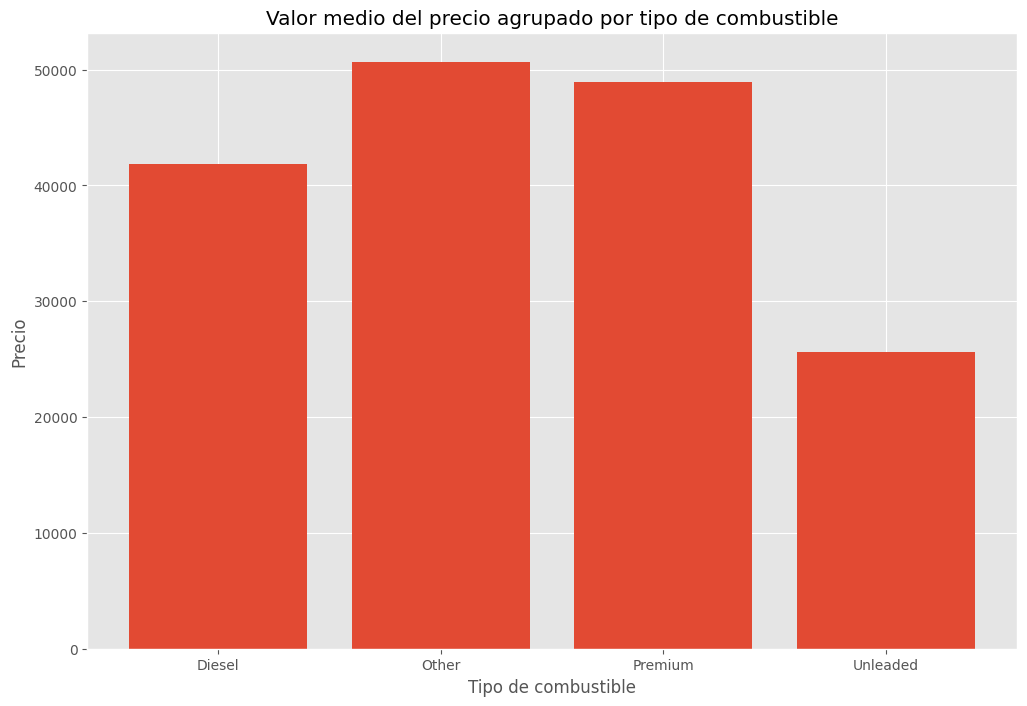

In [ ]:
# Varibales categóricas
FuelType_grouped = car[['FuelType', 'Price']].groupby('FuelType').mean().reset_index()
# Creating a bar chart
plt.bar(FuelType_grouped ['FuelType'], FuelType_grouped['Price'])
plt.title('Valor medio del precio agrupado por tipo de combustible')
plt.xlabel('Tipo de combustible')
plt.ylabel('Precio')

<BarContainer object of 2 artists>

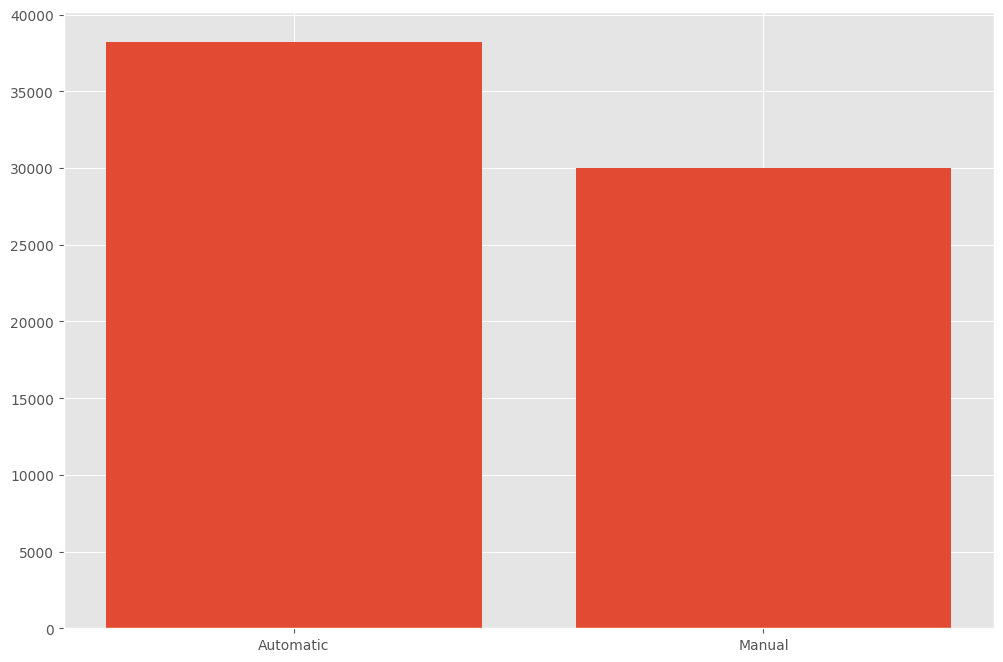

In [ ]:
# Varibales categóricas
Transmission_grouped = car[['Transmission', 'Price']].groupby('Transmission').mean().reset_index()
# Creating a bar chart
plt.bar(Transmission_grouped ['Transmission'], Transmission_grouped['Price'])

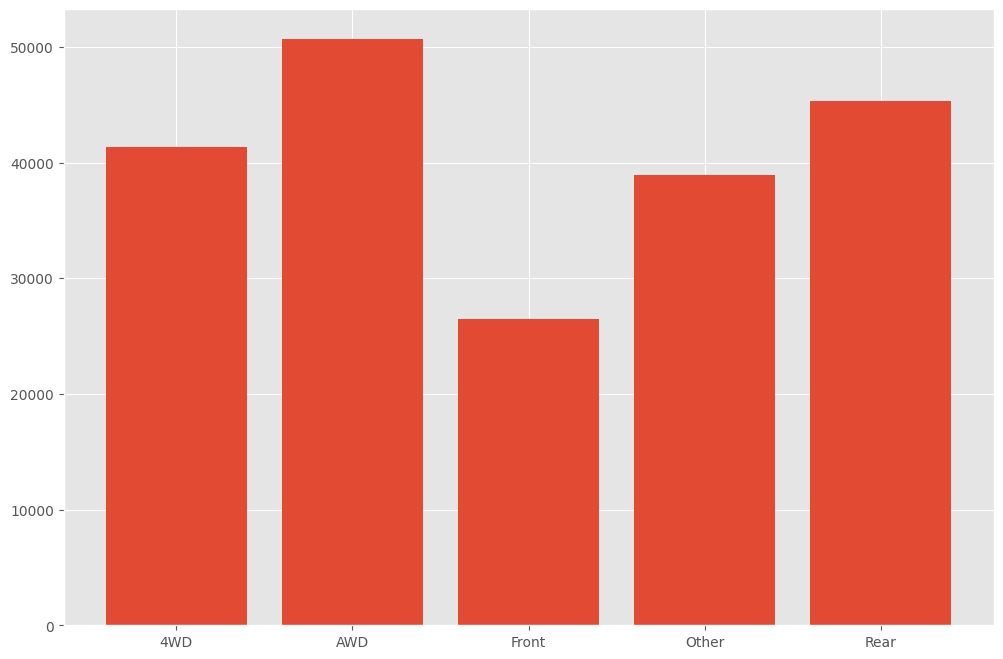

In [ ]:
# Varibales categóricas
DriveType_grouped = car[['DriveType', 'Price']].groupby('DriveType').mean().reset_index()
# Creating a bar chart
plt.bar(DriveType_grouped ['DriveType'], DriveType_grouped['Price'])
# Juntamos  4WD con Other
l = []
for i in car['DriveType']:
  if i == '4WD':
    l.append('Other')
  else :
    l.append(i)
car['DriveType'] = l

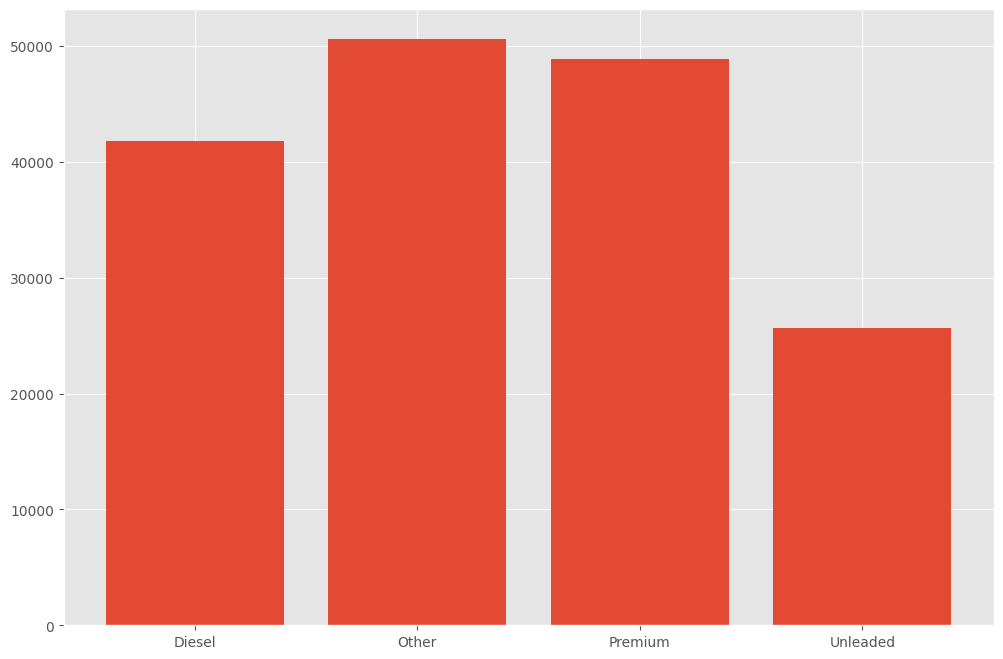

In [ ]:
# Varibales categóricas
FuelType_grouped = car[['FuelType', 'Price']].groupby('FuelType').mean().reset_index()
# Creating a bar chart
plt.bar(FuelType_grouped ['FuelType'], FuelType_grouped['Price'])
# Juntamos Diesel/Premium
l = []
for i in car['FuelType']:
  if i == 'Premium':
    l.append('Other')
  else :
    l.append(i)
car['FuelType'] = l

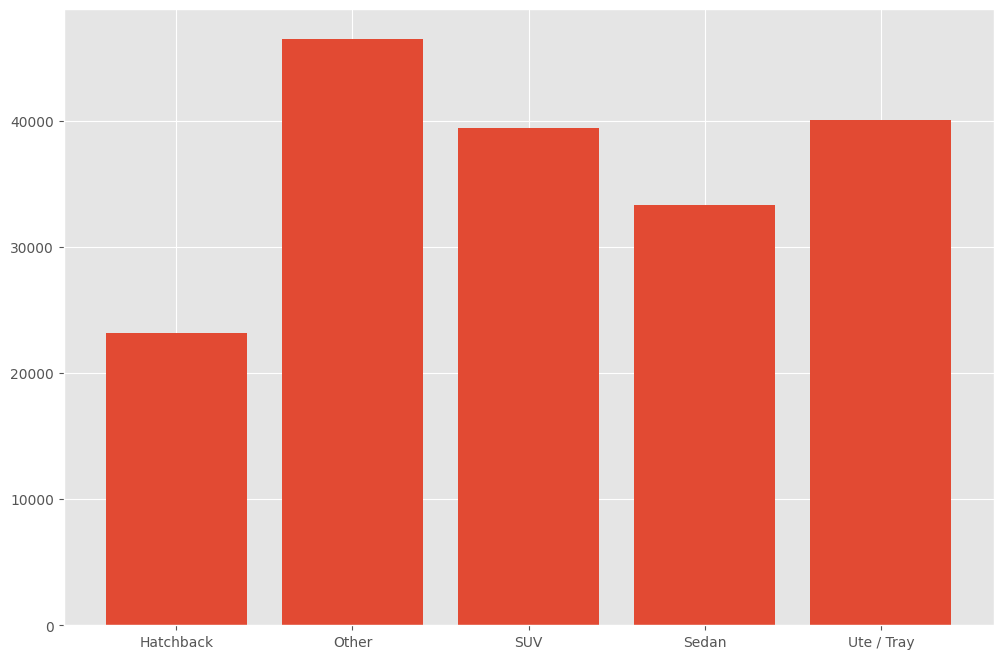

In [ ]:
# Varibales categóricas
BodyType_grouped = car[['BodyType', 'Price']].groupby('BodyType').mean().reset_index()
# Creating a bar chart
plt.bar(BodyType_grouped ['BodyType'], BodyType_grouped['Price'])
# Juntamos Ute/Tray con SUV
l = []
for i in car['BodyType']:
  if i == 'SUV' or i == 'Ute / Tray':
    l.append('SUV/Ute/Tray')
  else :
    l.append(i)
car['BodyType'] = l

# Outliers por columna

Year:


<Axes: >

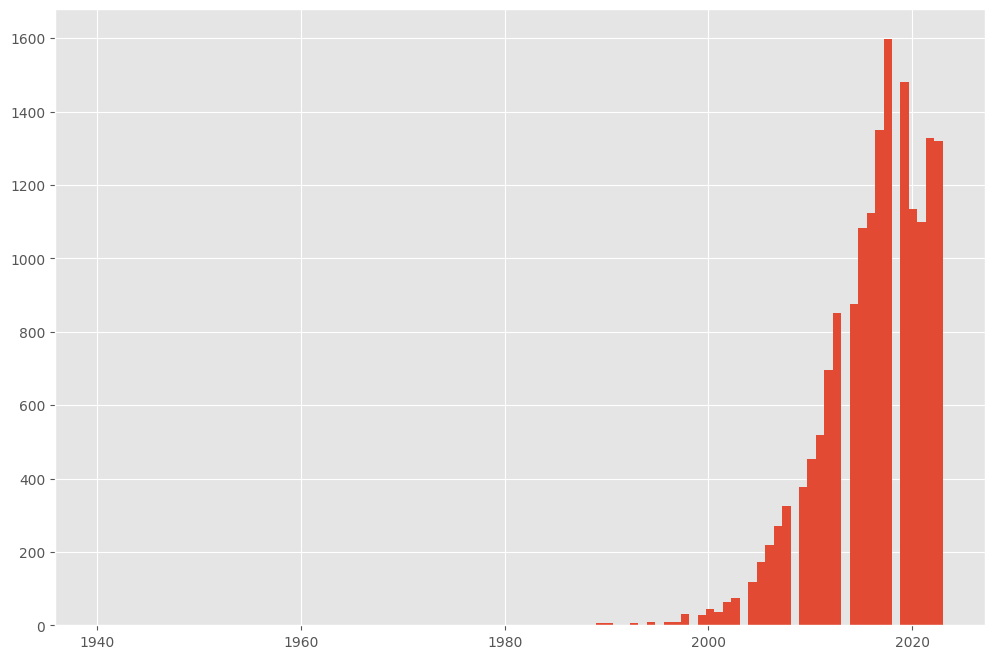

In [ ]:
# Year
print('Year:')
car['Year'].hist(bins=100)

<Axes: >

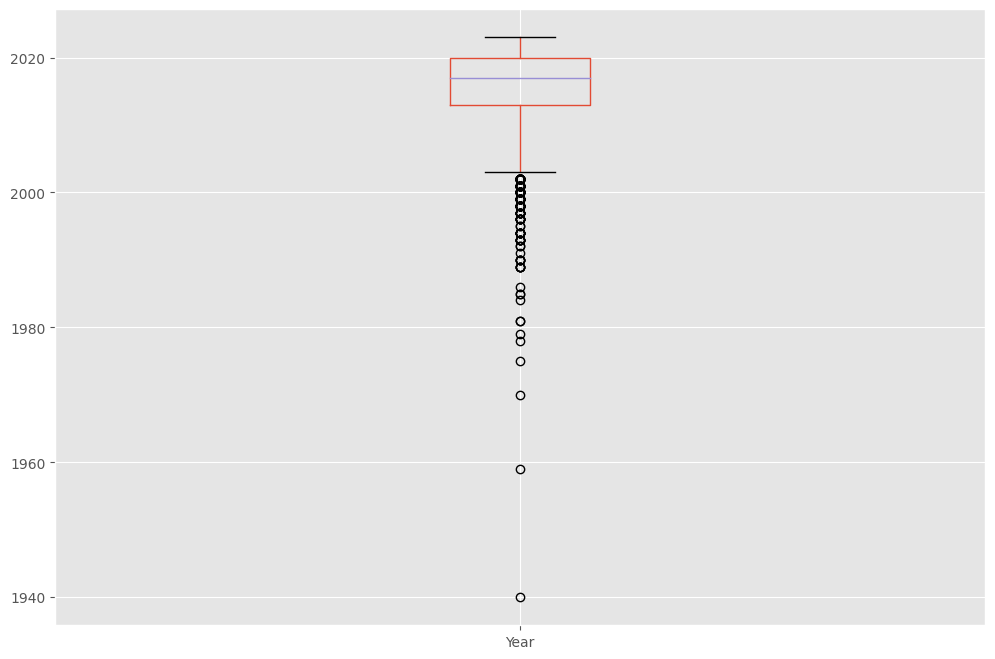

In [ ]:
# box plot.
car.boxplot(column=['Year'])

In [ ]:
# Eliminamos los registros con año de fabricación previo al 2002
print('Registros con Year < 2000:', car[car['Year'] < 2000].shape[0])
car.drop(car[car['Year'] < 2000].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros con Year < 2000: 119


Engine


<Axes: >

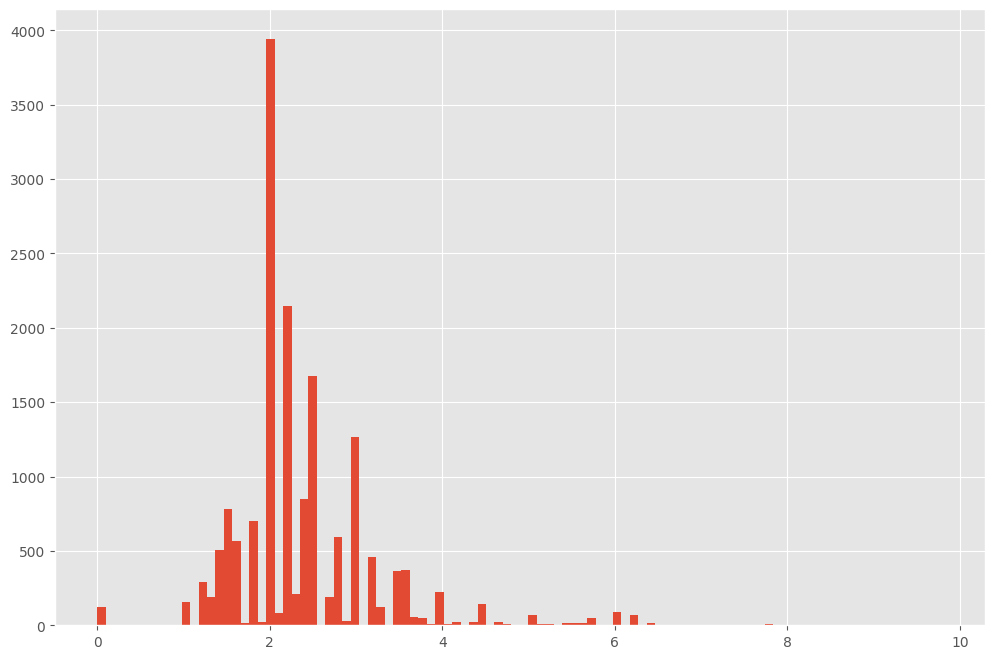

In [ ]:
# Engine
# Year
print('Engine')
car['Engine'].hist(bins=100)

<Axes: >

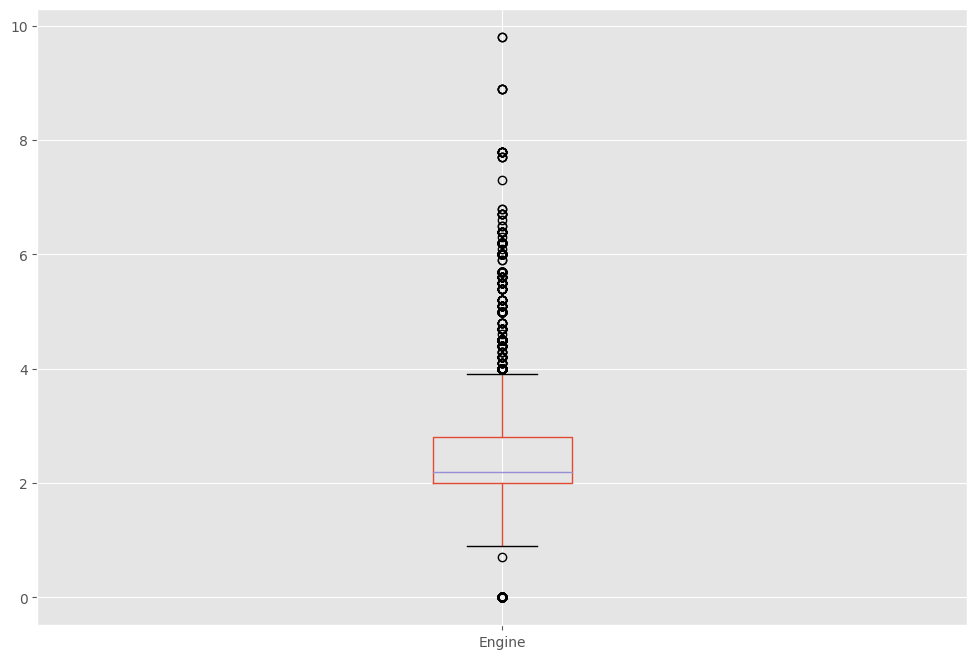

In [ ]:
# box plot.
car.boxplot(column=['Engine'])

In [ ]:
# Eliminamos los registros con año de fabricación previo al 2002
print('Registros con Engine > 6:', car[car['Engine'] > 6].shape[0])
print('Registros con Engine < 1:', car[car['Engine'] < 1].shape[0])
car.drop(car[car['Engine'] > 6].index, inplace = True)
car.drop(car[car['Engine'] < 1].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros con Engine > 6: 116
Registros con Engine < 1: 124


FuelConsumption


<Axes: >

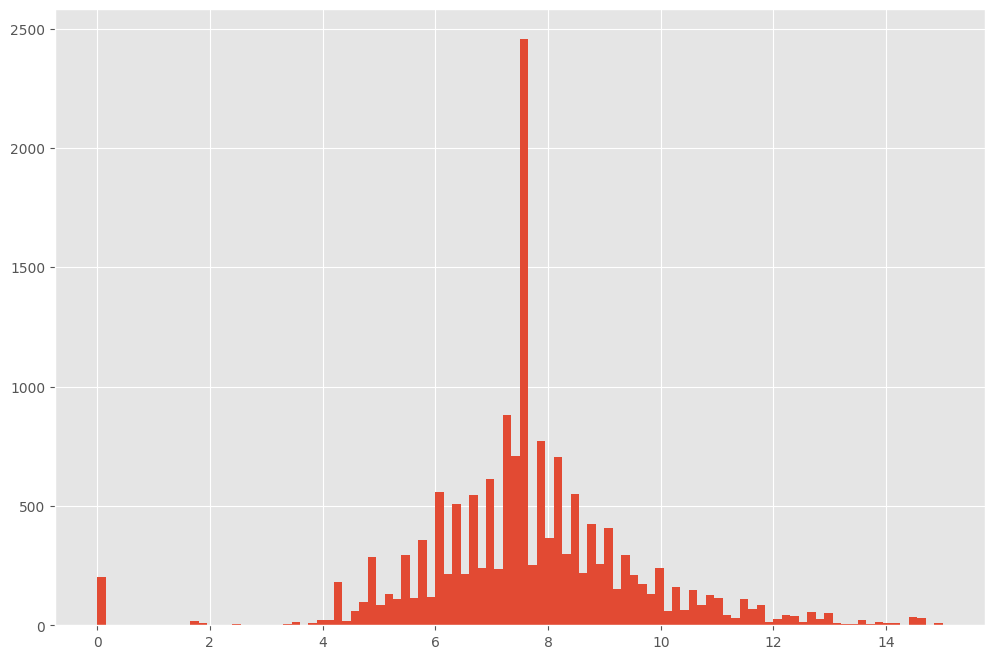

In [ ]:
# FuelConsumption
# Year
print('FuelConsumption')
car['FuelConsumption'].hist(bins=100)

Text(0.5, 1.0, 'Histograma de consumo de combustible después')

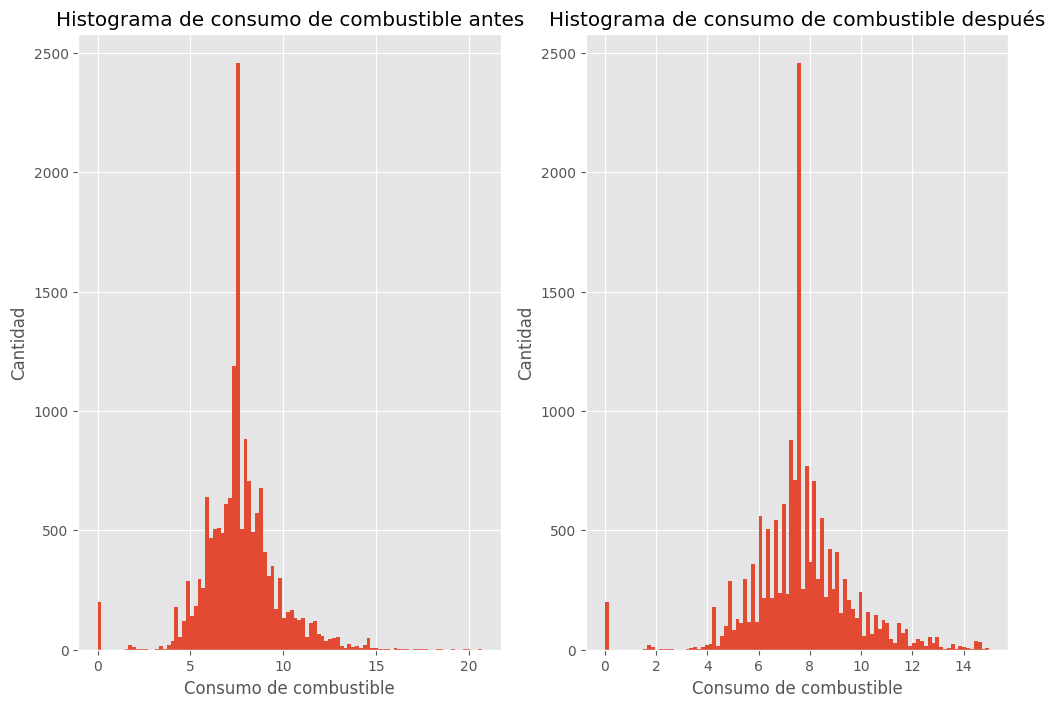

In [ ]:
l = []
for i in car['FuelConsumption']:
  if i <= 15:
    l.append(i)

s = pd.Series(l)

plt.subplot(1, 2, 1)

car['FuelConsumption'].hist(bins=100)
plt.xlabel('Consumo de combustible')
plt.ylabel('Cantidad')
plt.title('Histograma de consumo de combustible antes')

plt.subplot(1, 2, 2)
s.hist(bins=100)
plt.xlabel('Consumo de combustible')
plt.ylabel('Cantidad')
plt.title('Histograma de consumo de combustible después')

<Axes: >

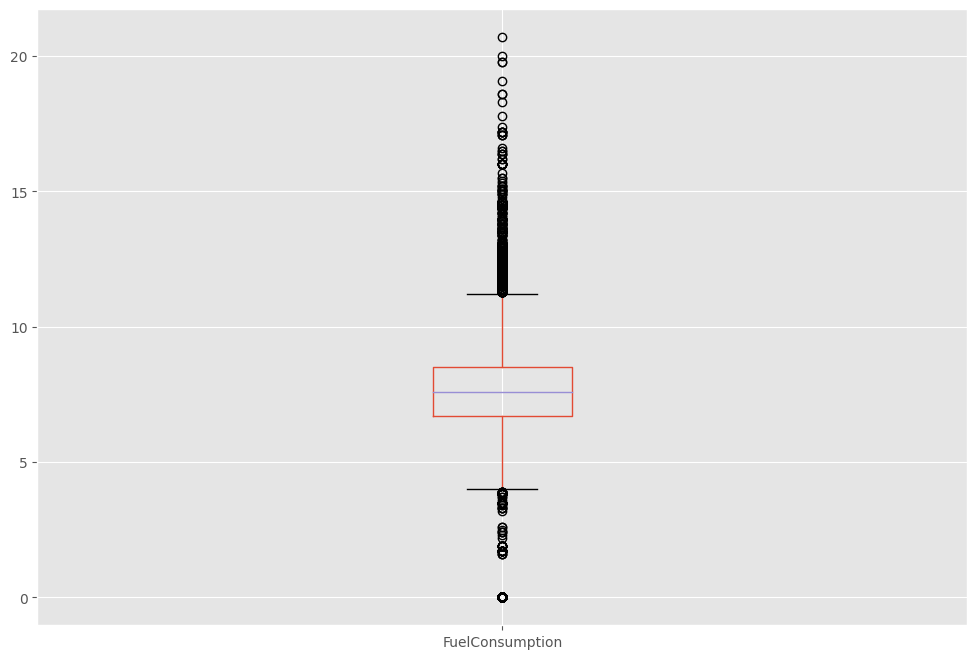

In [ ]:
# box plot.
car.boxplot(column=['FuelConsumption'])

In [ ]:
# Eliminamos los registros con año de fabricación previo al 2002
print('Registros con Fuel Consumption > 15:', car[car['FuelConsumption'] > 15].shape[0])
car.drop(car[car['FuelConsumption'] > 15].index, inplace = True)
#car.drop(car[car['Engine'] < 1].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros con Fuel Consumption > 15: 47


In [ ]:
car[car['FuelConsumption']==0]['FuelType'].value_counts()

Diesel      146
Unleaded     44
Other        12
Name: FuelType, dtype: int64

In [ ]:
car['FuelType'].value_counts()

Unleaded    6894
Diesel      4846
Other       4588
Name: FuelType, dtype: int64

Kilometres


<Axes: >

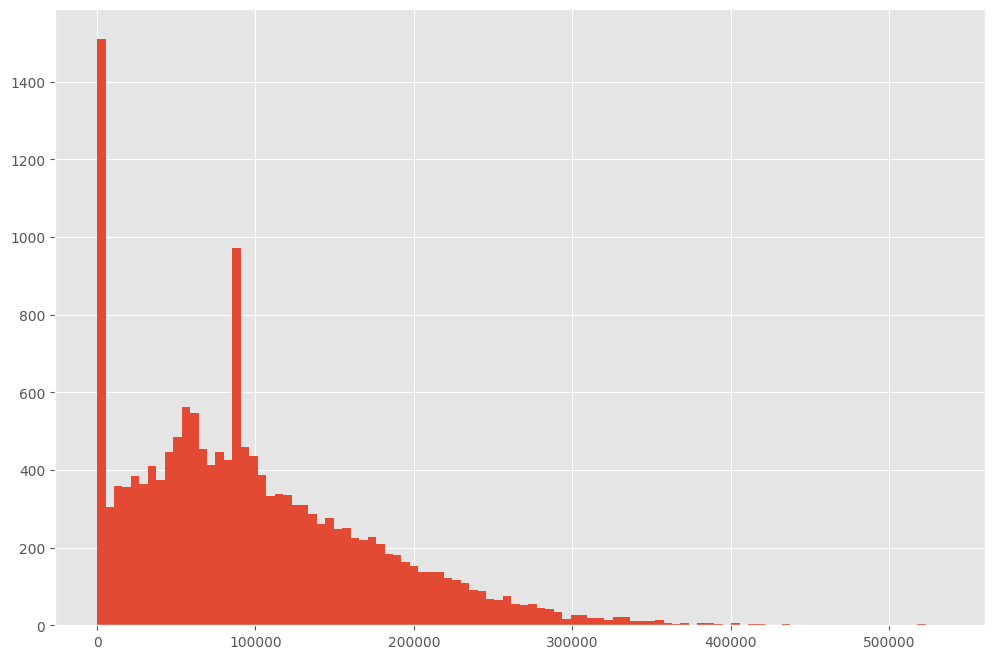

In [ ]:
# FuelConsumption
# Year
print('Kilometres')
car['Kilometres'].hist(bins=100)

<Axes: >

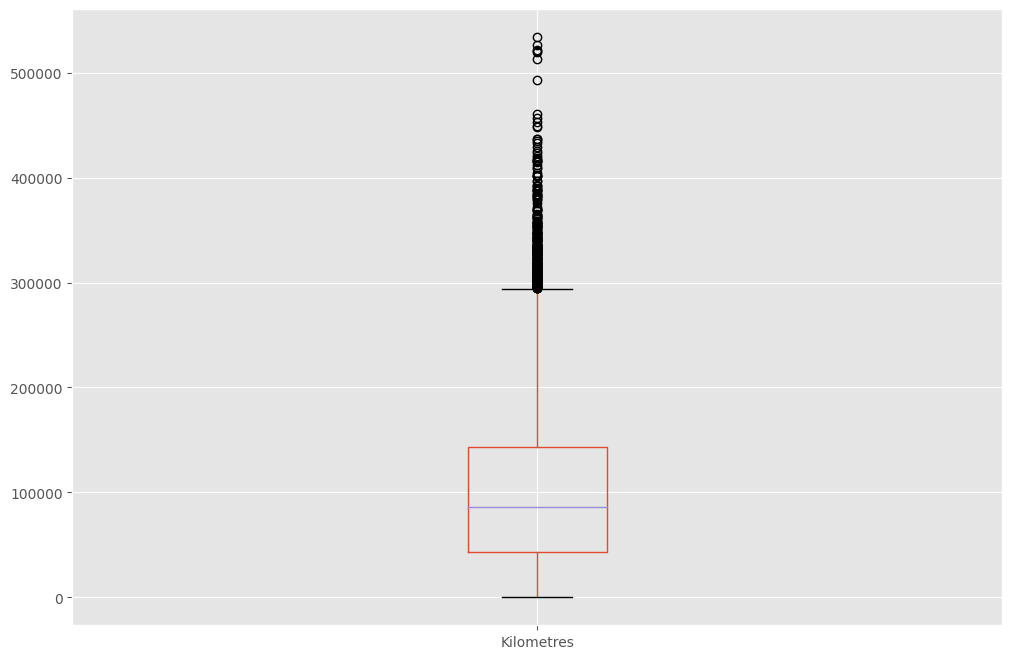

In [ ]:
# box plot.
car.boxplot(column=['Kilometres'])

In [ ]:
# Eliminamos los registros con año de fabricación previo al 2002
print('Registros Kilometres > 350000:', car[car['Kilometres'] > 350000].shape[0])
car.drop(car[car['Kilometres'] > 350000].index, inplace = True)
#car.drop(car[car['Engine'] < 1].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros Kilometres > 350000: 87


Price


<Axes: >

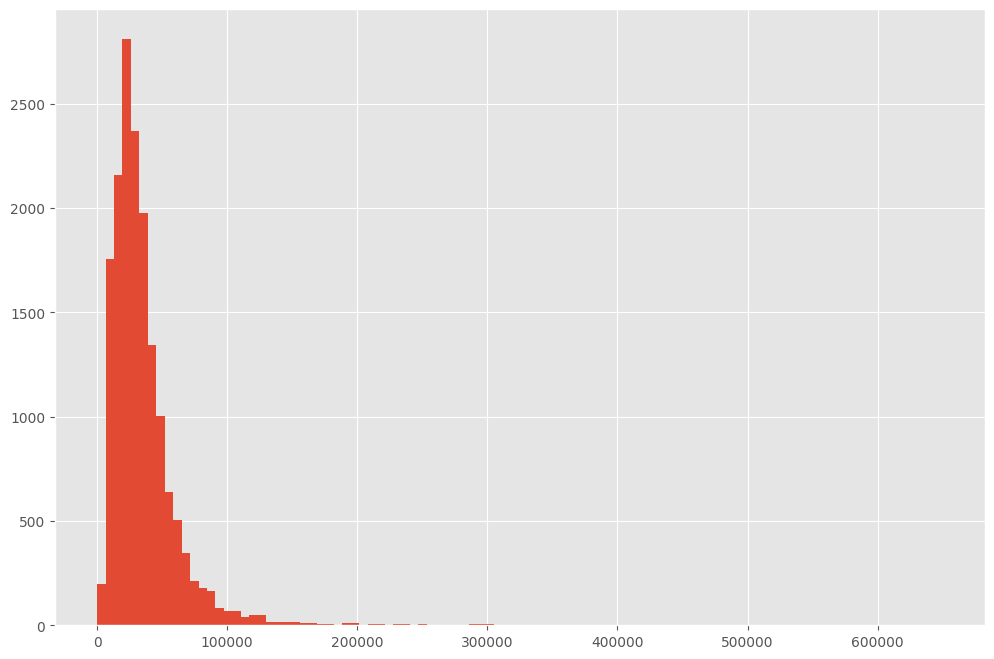

In [ ]:
# FuelConsumption
# Year
print('Price')
car['Price'].hist(bins=100)

<Axes: >

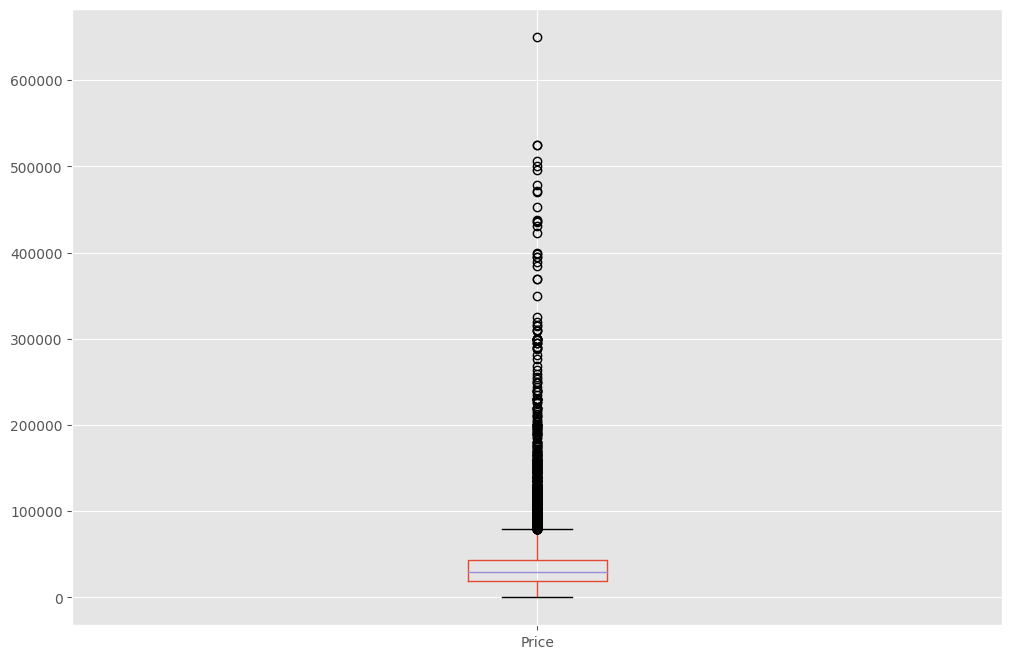

In [ ]:
# box plot.
car.boxplot(column=['Price'])

Text(0.5, 1.0, 'Diagrama de cajas del precio después')

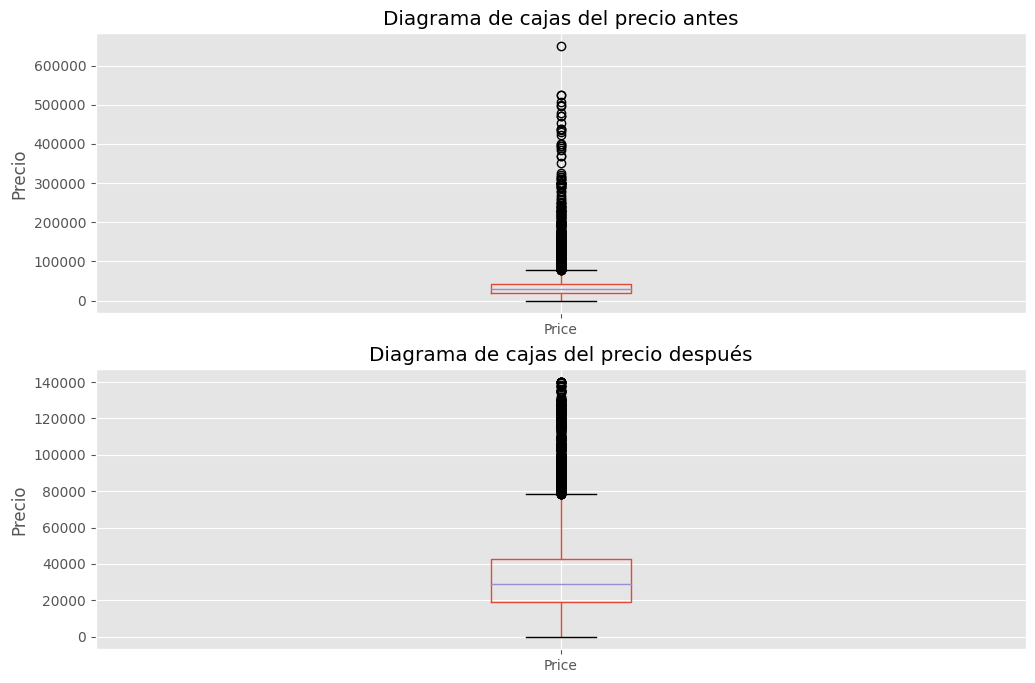

In [ ]:
l = []
p = pd.DataFrame()
for i in car['Price']:
  if i <= 140000:
    l.append(i)

s = pd.Series(l)
p['Price'] = s

plt.subplot(2, 1, 1)

car.boxplot(column=['Price'])
plt.ylabel('Precio')
plt.title('Diagrama de cajas del precio antes')

plt.subplot(2, 1, 2)
p.boxplot(column=['Price'])
plt.ylabel('Precio')
plt.title('Diagrama de cajas del precio después')

In [ ]:
# Eliminamos los registros que tienen un Time_Affect superior a 4000.
print('Registros:', car[car['Price'] > 140000].shape[0])
#print('Registros:', car[car['Price'] < 1000].shape[0])
car.drop(car[car['Price'] > 140000].index, inplace = True)
#car.drop(car[car['Price'] < 1000].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros: 185


Cylinders


<Axes: >

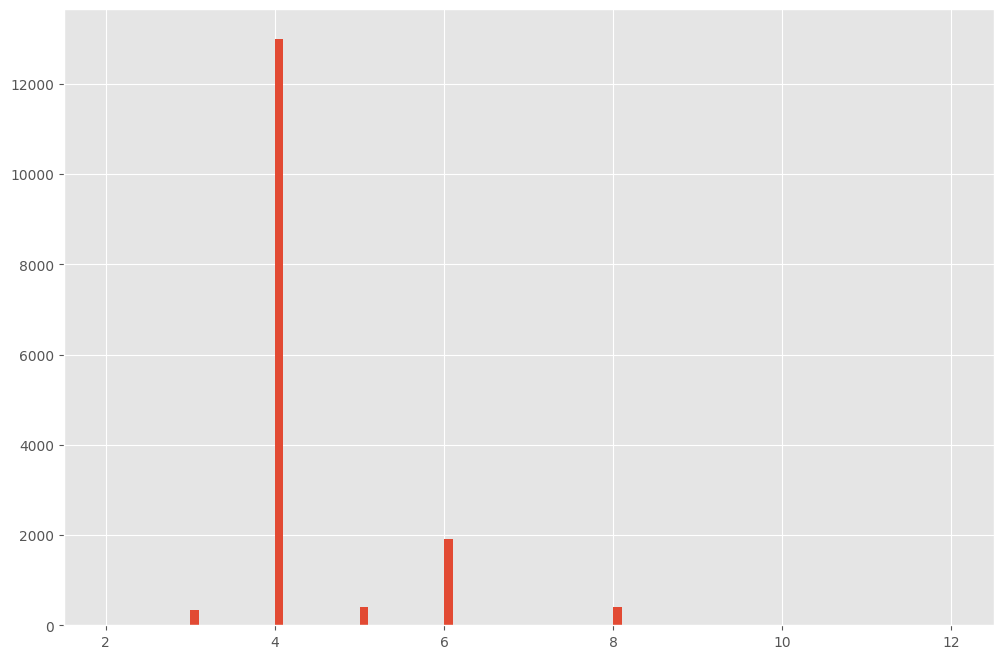

In [ ]:
# FuelConsumption
# Year
print('Cylinders')
car['Cylinders'].hist(bins=100)

In [ ]:
car['Cylinders'].describe()

count     16145.0
mean     4.342583
std      0.900259
min           2.0
25%           4.0
50%           4.0
75%           4.0
max          12.0
Name: Cylinders, dtype: Float64

In [ ]:
print('Registros:', car[car['Cylinders'] > 8].shape[0])
print('Registros:', car[car['Cylinders'] < 3].shape[0])
car.drop(car[car['Cylinders'] > 8].index, inplace = True)
car.drop(car[car['Cylinders'] < 3].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros: 2
Registros: 1


Doors


<Axes: >

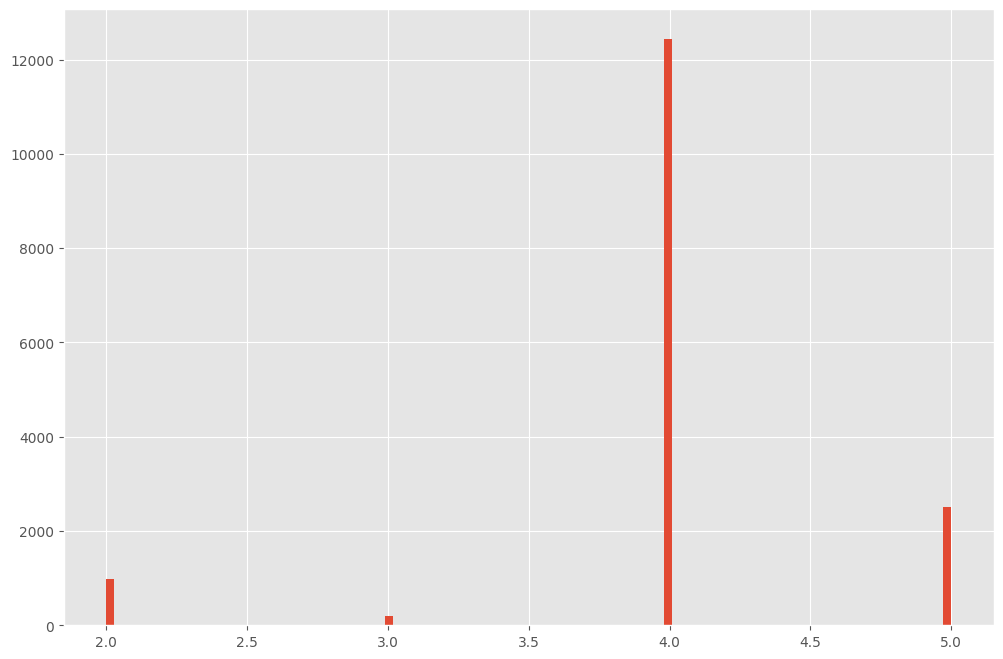

In [ ]:
# FuelConsumption
# Year
print('Doors')
car['Doors'].hist(bins=100)

In [ ]:
car['Doors'].describe()

count     16053.0
mean      4.02199
std      0.640114
min           2.0
25%           4.0
50%           4.0
75%           4.0
max           5.0
Name: Doors, dtype: Float64

In [ ]:
print('Registros:', car[car['Doors'] > 4].shape[0])
print('Registros:', car[car['Doors'] < 3].shape[0])
car.reset_index(drop = True, inplace = True)

Registros: 2496
Registros: 973


Seats


<Axes: >

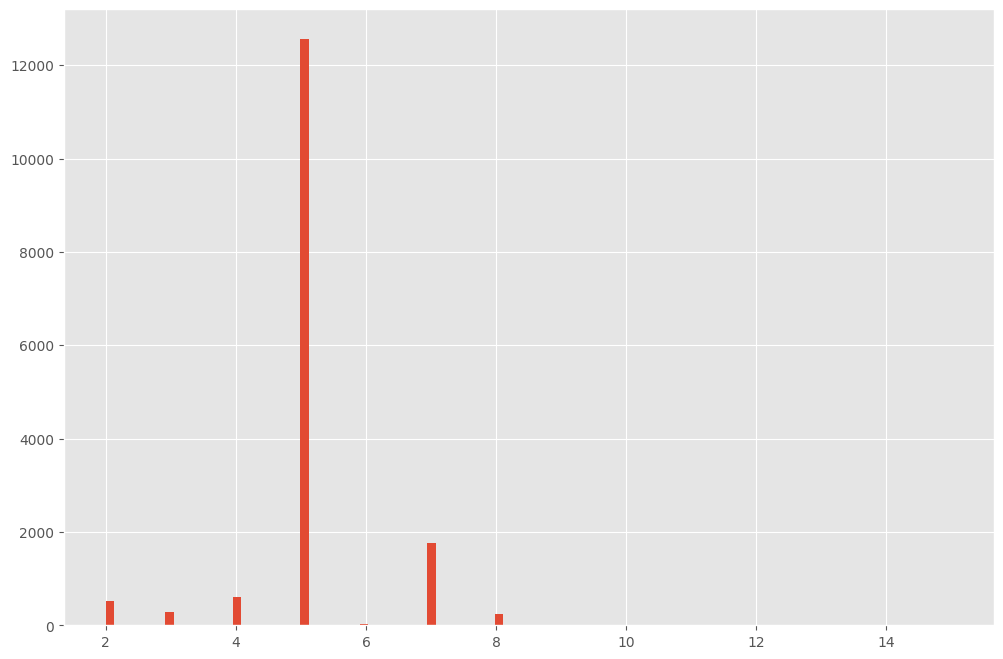

In [ ]:
# FuelConsumption
# Year
print('Seats')
car['Seats'].hist(bins=100)

In [ ]:
car['Seats'].describe()

count     16053.0
mean     5.103532
std        1.0268
min           2.0
25%           5.0
50%           5.0
75%           5.0
max          15.0
Name: Seats, dtype: Float64

In [ ]:
print('Registros:', car[car['Seats'] > 8].shape[0])
car.drop(car[car['Seats'] > 8].index, inplace = True)
car.reset_index(drop = True, inplace = True)

Registros: 20


In [ ]:
# Variables categóricas
print('El dataset contiene', car.shape[0], 'filas y', car.shape[1], 'columnas.')
print('Las columnas, con sus correspondientes tipos, son las siguientes:\n', car.dtypes)

El dataset contiene 16033 filas y 15 columnas.
Las columnas, con sus correspondientes tipos, son las siguientes:
 Year                  Int64
UsedOrNew            object
Transmission         object
Engine              float64
DriveType            object
FuelType             object
FuelConsumption     float64
Kilometres          float64
Cylinders             Int64
BodyType             object
Doors                 Int64
Seats                 Int64
Price               float64
DollarAustralian    float64
PriceIndex          float64
dtype: object


Text(0.5, 1.0, 'Diagrama de columnas del estado del vehículo')

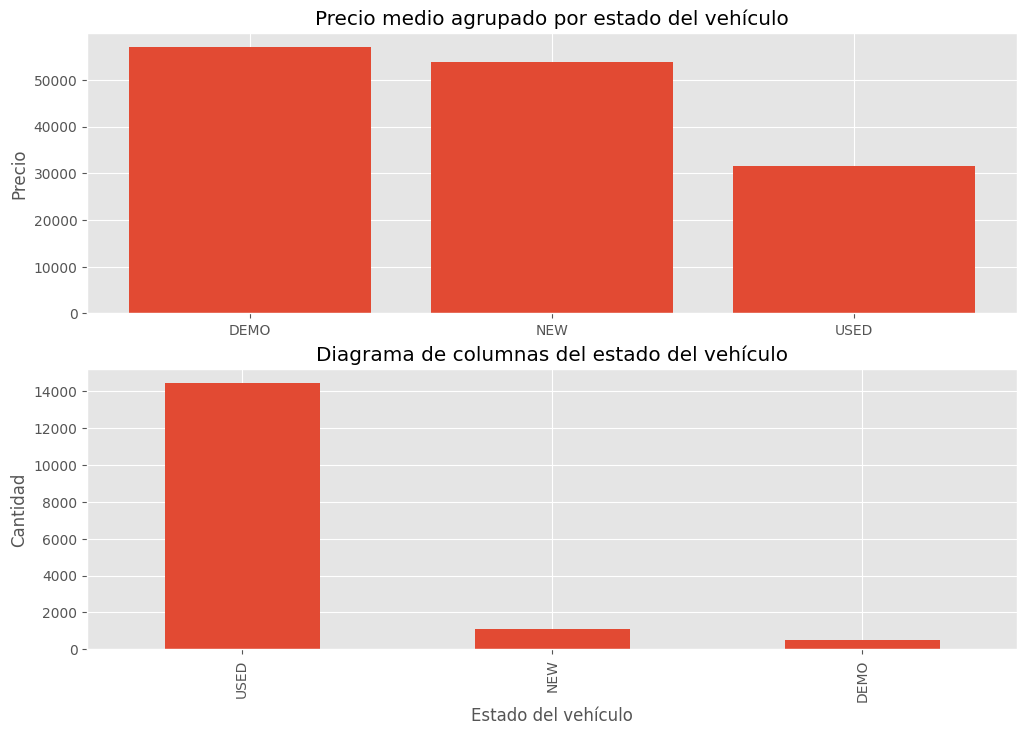

In [ ]:
plt.subplot(2, 1, 1)
UsedOrNew_grouped = car[['UsedOrNew', 'Price']].groupby('UsedOrNew').mean().reset_index()
plt.bar(UsedOrNew_grouped ['UsedOrNew'], UsedOrNew_grouped['Price'])
plt.ylabel('Precio')
plt.title('Precio medio agrupado por estado del vehículo')



plt.subplot(2, 1, 2)
car['UsedOrNew'].value_counts().plot.bar()
plt.ylabel('Cantidad')
plt.xlabel('Estado del vehículo')
plt.title('Diagrama de columnas del estado del vehículo')

USED    14446
NEW      1102
DEMO      485
Name: UsedOrNew, dtype: int64


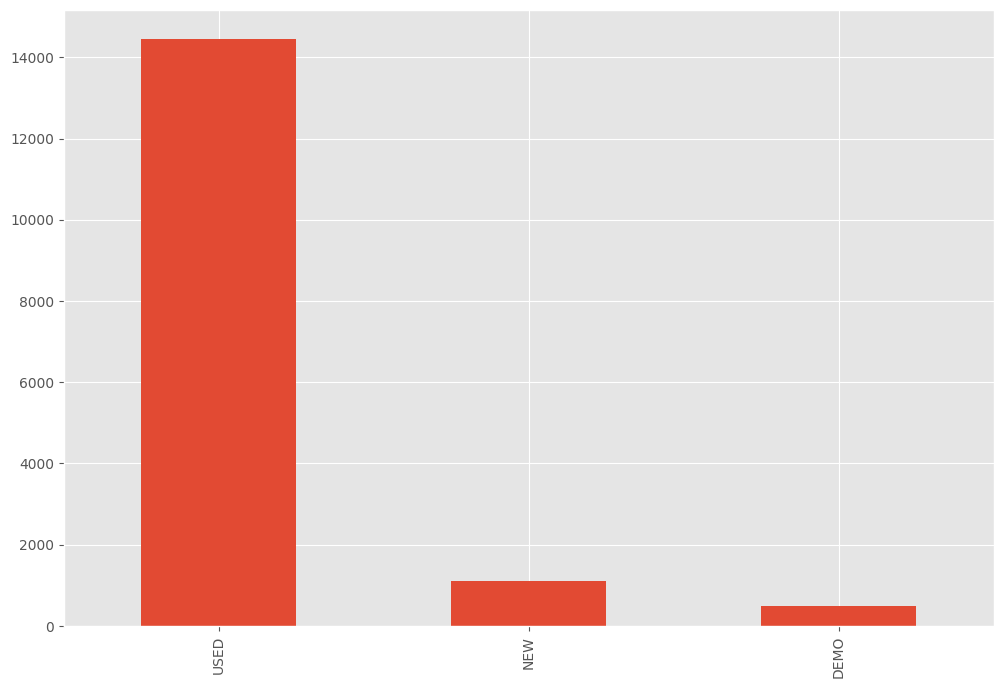

In [ ]:
# UsedOrNew.
print(car['UsedOrNew'].value_counts())
car['UsedOrNew'].value_counts().plot.bar()

# Juntamos DEMO con NEW (además tienen precio medio similar), el hecho de que solo haya 500 lo refuerza
l = []
for i in car['UsedOrNew']:
  if i == 'DEMO' or i == 'NEW':
    l.append('NOT USED')
  else :
    l.append(i)
car['UsedOrNew'] = l

Automatic    14212
Manual        1821
Name: Transmission, dtype: int64


<Axes: >

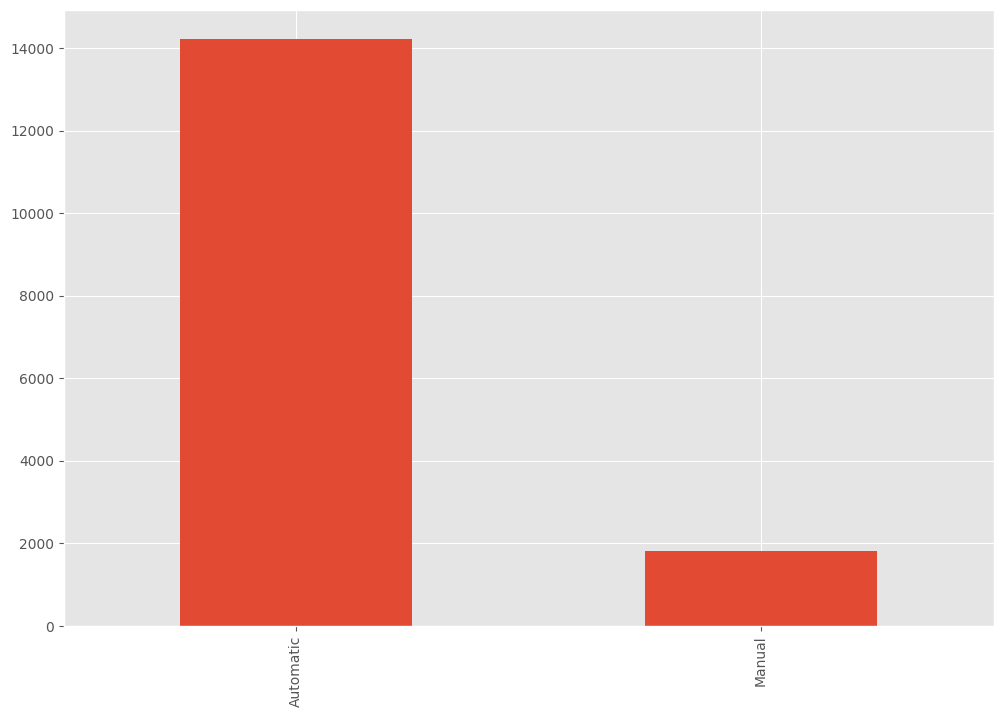

In [ ]:
# Transmission
print(car['Transmission'].value_counts())
car['Transmission'].value_counts().plot.bar()

Front    6883
Other    4110
AWD      2972
Rear     2068
Name: DriveType, dtype: int64


<Axes: >

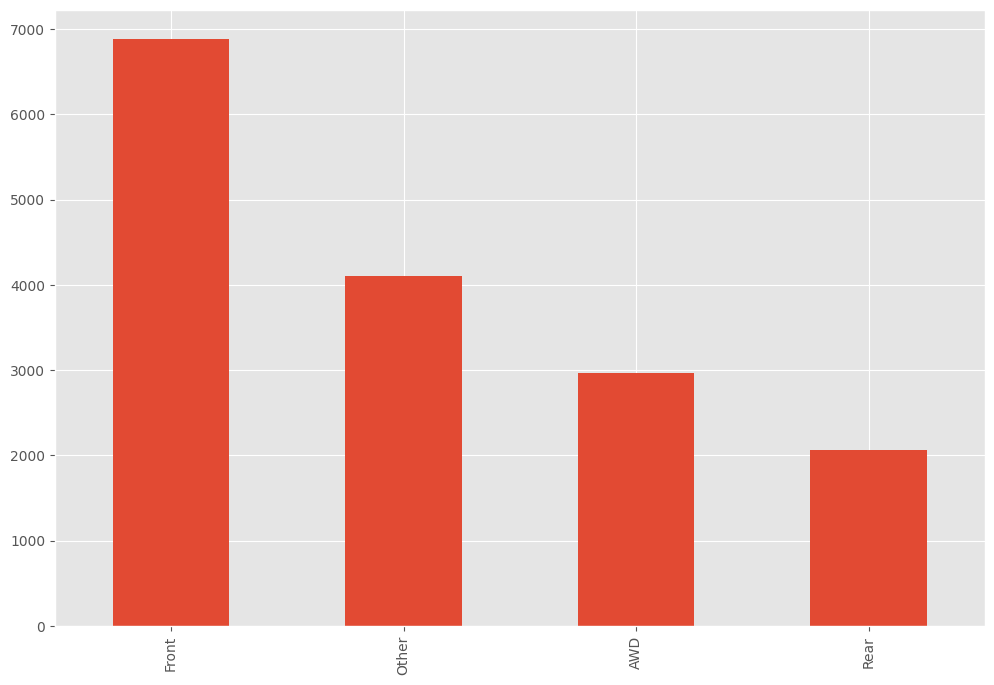

In [ ]:
# DriveType
print(car['DriveType'].value_counts())
car['DriveType'].value_counts().plot.bar()

Unleaded    6855
Diesel      4743
Other       4435
Name: FuelType, dtype: int64


<Axes: >

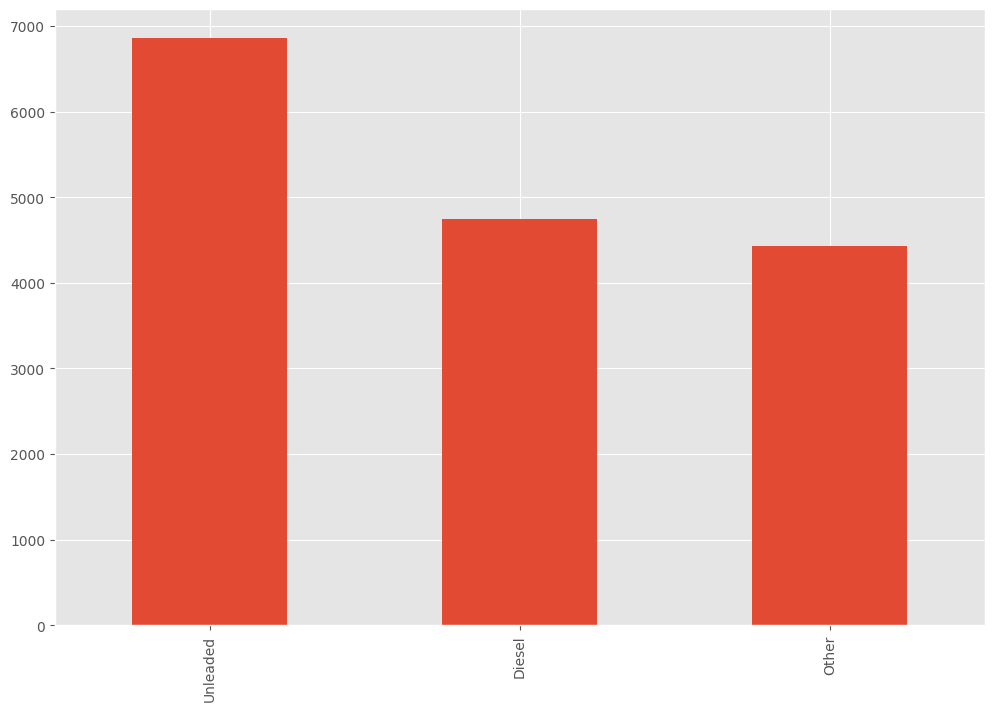

In [ ]:
# FuelType
print(car['FuelType'].value_counts())
car['FuelType'].value_counts().plot.bar()

SUV/Ute/Tray    9119
Hatchback       2655
Other           2416
Sedan           1843
Name: BodyType, dtype: int64


<Axes: >

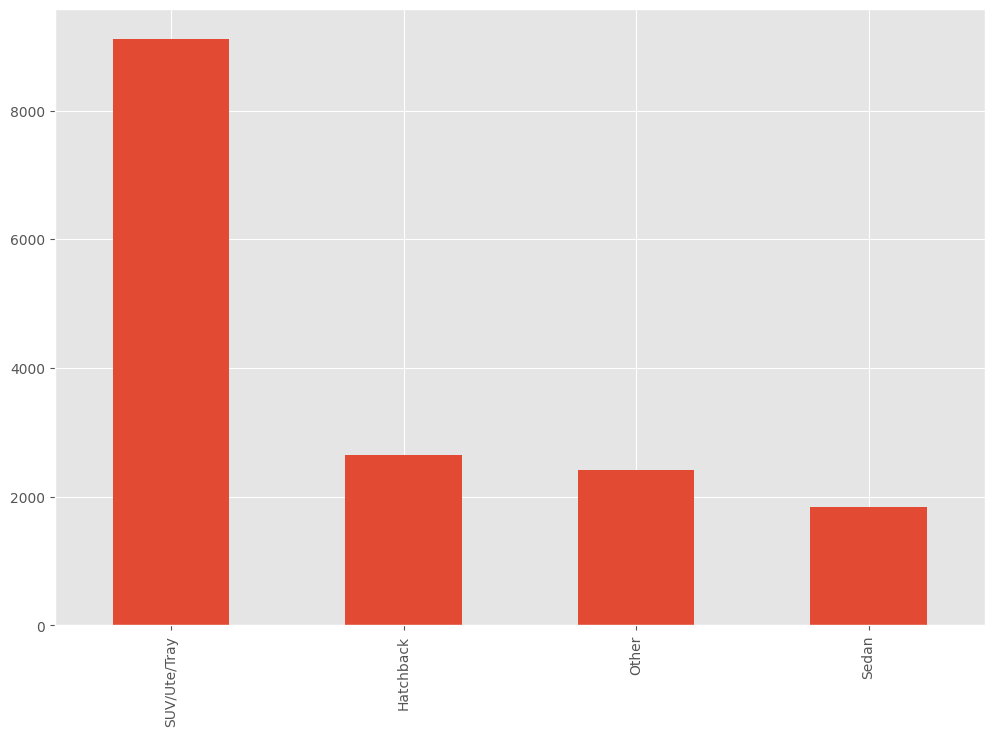

In [ ]:
# BodyType
print(car['BodyType'].value_counts())
car['BodyType'].value_counts().plot.bar()

# Outliers por filas (DBSCAN)

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
num_cols = ['Year', 'Engine', 'FuelConsumption', 'Kilometres', 'Cylinders', 'Doors', 'Seats', 'DollarAustralian', 'PriceIndex', 'Price']
features_norm = min_max_scaler.fit_transform(car[num_cols])

## DBSCAN
from scipy import cluster
import sklearn.metrics

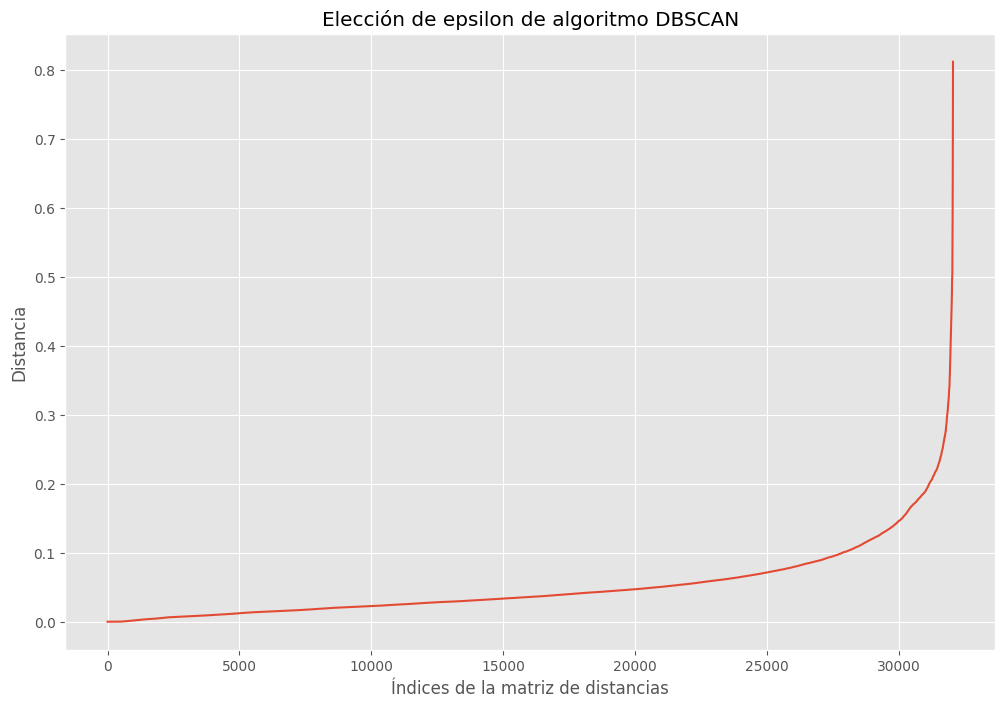

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
num_cols = ['Year', 'Engine', 'FuelConsumption', 'Kilometres', 'Cylinders', 'Doors', 'Seats', 'DollarAustralian', 'PriceIndex', 'Price']
features_norm = min_max_scaler.fit_transform(car[num_cols])

## DBSCAN
from scipy import cluster
import sklearn.metrics
dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
matdist= dist.pairwise(features_norm)
minPts=2
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(features_norm, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(features_norm):
    for j in range(len(features_norm)):
        if Ar[i][j] != 0:
            seq.append(matdist[i][j])

seq.sort()
# establecer intervalo ejes
fig = plt.figure()
ax = fig.gca()
#ax.set_xticks(np.arange(0, 120, 10))
#ax.set_yticks(np.arange(0, 7, 0.5))

plt.plot(seq)
plt.xlabel('Índices de la matriz de distancias')
plt.ylabel('Distancia')
plt.title('Elección de epsilon de algoritmo DBSCAN')

plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
print("Para los distintos epsilons, se muestra el número de clústers y outliers obtenidos con el método DBSCAN:\n")
for eps in np.arange(0.05, 0.45, 0.05):
  db = DBSCAN(eps, min_samples=minPts).fit(features_norm)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))


#labels

Para los distintos epsilons, se muestra el número de clústers y outliers obtenidos con el método DBSCAN:

  0.05, 1395, 4412
  0.10, 722, 1550
  0.15, 427, 674
  0.20, 235, 320
  0.25, 96, 135
  0.30, 62, 72
  0.35, 36, 41
  0.40, 28, 29


In [ ]:
# Prescindimos de los 72 registros más extremos, a fin de evitar distorsionar los resultados
eps= 0.3
db = DBSCAN(eps, min_samples=minPts).fit(features_norm)
labels = db.labels_


In [ ]:
j = 0
l = []
for i in labels:
  if i == -1:
    l.append(j)
  j = j+1

car.drop(l, axis=0, inplace=True)
car.reset_index(drop = True, inplace = True)

In [ ]:
print('El dataset contiene', car.shape[0], 'filas y', car.shape[1], 'columnas.')
print('Las columnas, con sus correspondientes tipos, son las siguientes:\n', car.dtypes)

El dataset contiene 15961 filas y 15 columnas.
Las columnas, con sus correspondientes tipos, son las siguientes:
 Year                  Int64
UsedOrNew            object
Transmission         object
Engine              float64
DriveType            object
FuelType             object
FuelConsumption     float64
Kilometres          float64
Cylinders             Int64
BodyType             object
Doors                 Int64
Seats                 Int64
Price               float64
DollarAustralian    float64
PriceIndex          float64
dtype: object


# Datos innecesarios

## Datos desinformativos

In [ ]:
num_rows = len(car.index)
low_information_cols = []

for col in car.columns:
    cnts = car[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]

    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

## Datos Duplicados

In [ ]:
# we know that column 'id' is unique, but what if we drop it?
car_dedupped = car.drop_duplicates()

# there were duplicate rows
print(car.shape)
print(car_dedupped .shape)

#Dekete duplicates
car.drop_duplicates(inplace = True)

(15961, 15)
(15891, 15)


In [ ]:
print('El dataset contiene', car.shape[0], 'filas y', car.shape[1], 'columnas.')
print('Las columnas, con sus correspondientes tipos, son las siguientes:\n', car.dtypes)

El dataset contiene 15891 filas y 15 columnas.
Las columnas, con sus correspondientes tipos, son las siguientes:
 Year                  Int64
UsedOrNew            object
Transmission         object
Engine              float64
DriveType            object
FuelType             object
FuelConsumption     float64
Kilometres          float64
Cylinders             Int64
BodyType             object
Doors                 Int64
Seats                 Int64
Price               float64
DollarAustralian    float64
PriceIndex          float64
dtype: object


# Anexo y exportación de resultados

Finalmente, confirmamos que la variable del precio toma valores enteros y exportamos el fichero final listo para la siguiente fase de modelado.

In [ ]:
aux = True
for i in car['Price']: # Recorremos el campo.
  if not(i.is_integer()): # Preguntamos si es real.
    aux = False # Si hay algún número real en este campo aux será falso.
    break

# En caso de que solo haya valores enteros en ambos campos (sin contar los Missings), aux y aux2 serán True.
print('¿Los valores de Price son enteros?', aux)

¿Los valores de Price son enteros? True


In [ ]:
car.to_csv('Australian vehicle Prices Clean.csv', index = False)